## Walkthrough

This notebook brings together all of the work we have done thus far. It's split into six sections:
- Parameters:
        Defines which seasons to pull and generate data from
- Web:
        Scraps data for seasons from https://www.pro-football-reference.com/ and stores in pickle files
- Data:
        Standardizes the raw data generated by the scraper
- Model:
        Transforms data into feature sets for model training
- Sim:
        Loads all competition data and trains models
- Double Up Backtest:
        Simulates historic competitions using several strategies, records the performance and plots the performance for each strategy 
        

In [1]:
import os
import pickle
import numpy as np
import sys

from tqdm import tqdm
from os.path import expanduser

# add path to directory that contains web.py to system
sys.path.insert(0, os.path.join(expanduser("~"), "teachdfs"))
from web import FootballBoxscore, unique_game_links
from config import CACHE_DIRECTORY

## Parameters


In [2]:
seasons = [2018, 2019, 2020]

## Web

In [3]:
all_scores = {}
for season in seasons:
    links = unique_game_links(season)
    all_scores[season] = [FootballBoxscore("https://www.pro-football-reference.com/" + link) for link in links]
    
    for fbs in tqdm(all_scores[season]):
        try: 
            fbs.full_scrape()
        except AttributeError:
            print("Advanced Table Not Found")
            break

    # Cache the results
    if not os.path.exists(CACHE_DIRECTORY):
        os.makedirs(CACHE_DIRECTORY)
    
    data_path = os.path.join(CACHE_DIRECTORY, f"{season}_box.pkl")
    pickle.dump(all_scores[season], open(data_path,'wb'))

100%|██████████| 269/269 [03:06<00:00,  1.44it/s]


## Data

In [4]:
from data import ScoreTable, OffenseTable, DefenseTeamTable, OffenseTeamTable
from data import AdvancedPassingTable, AdvancedReceivingTable, AdvancedRushingTable 

In [5]:
# Feature space classes will get references to these, so make sure they are built
for season in seasons:
    score_table        = ScoreTable(refresh=True, season=season, boxscores=all_scores[season])
    offense_table      = OffenseTable(refresh=True, season=season, boxscores=all_scores[season])
    adv_passing_table  = AdvancedPassingTable(refresh=True, season=season, boxscores=all_scores[season])
    adv_recv_table     = AdvancedReceivingTable(refresh=True, season=season, boxscores=all_scores[season])
    adv_rush_table     = AdvancedRushingTable(refresh=True, season=season, boxscores=all_scores[season])
    defense_table      = DefenseTeamTable(refresh=True, season=season, boxscores=all_scores[season])
    offense_team_table = OffenseTeamTable(refresh=True, season=season, boxscores=all_scores[season])

100%|██████████| 269/269 [00:01<00:00, 173.24it/s]


## Model

In [6]:
from model import QuarterbackFeatureSpaceTable, PositionPlayerFeatureSpaceTable, DefenseFeatureSpaceTable

In [7]:
qb_featurespace    = QuarterbackFeatureSpaceTable(seasons=seasons)
pl_featurespace    = PositionPlayerFeatureSpaceTable(seasons=seasons)
df_featurespace    = DefenseFeatureSpaceTable(seasons=seasons)

1490it [00:18, 79.77it/s]
12802it [03:14, 65.99it/s]
1450it [00:12, 117.08it/s]


## Sim

In [8]:
from sim import PayoutTable, BacktestLinksTable, HistoricalSalaryTable, BacktestStandingsTable
from sim import BacktestPlayerPerformanceTable, BacktestPredictionsTable

In [9]:
payoutTable           = PayoutTable(refresh=True)
backtestLinks         = BacktestLinksTable(refresh=True)
historicalSalary      = HistoricalSalaryTable(refresh=True, seasons=seasons)
historicalStandings   = BacktestStandingsTable(refresh=True)
historicalPerformance = BacktestPlayerPerformanceTable(refresh=True, seasons=seasons)
backtestPredictions   = BacktestPredictionsTable(refresh=True, seasons=seasons)

100%|██████████| 45/45 [00:12<00:00,  3.52it/s]
10it [00:08,  1.11it/s]
100%|██████████| 45/45 [00:11<00:00,  3.75it/s]
10it [00:08,  1.23it/s]
100%|██████████| 45/45 [00:11<00:00,  3.79it/s]
10it [00:08,  1.22it/s]
45it [00:00, 78.98it/s]
380it [00:05, 66.47it/s]
26it [00:00, 112.76it/s]
43it [00:00, 81.58it/s]
380it [00:05, 65.54it/s]
26it [00:00, 115.00it/s]
36it [00:00, 81.11it/s]
322it [00:05, 64.17it/s]
22it [00:00, 107.69it/s]
44it [00:00, 79.99it/s]
344it [00:05, 67.18it/s]
24it [00:00, 114.75it/s]
41it [00:00, 80.34it/s]
308it [00:04, 65.32it/s]
22it [00:00, 104.25it/s]
43it [00:00, 81.12it/s]
338it [00:05, 66.31it/s]
24it [00:00, 115.35it/s]
42it [00:00, 79.18it/s]
346it [00:05, 64.86it/s]
22it [00:00, 103.63it/s]
40it [00:00, 80.26it/s]
308it [00:04, 65.58it/s]
22it [00:00, 112.63it/s]
47it [00:00, 78.70it/s]
349it [00:05, 65.72it/s]
22it [00:00, 106.18it/s]
41it [00:00, 79.98it/s]
313it [00:04, 65.93it/s]
22it [00:00, 112.25it/s]


## Double Up Backtest

In [10]:
from sim import DoubleupStandingsTable

In [11]:
historicalPerformance = BacktestPlayerPerformanceTable(refresh=False, seasons=seasons)
backtestPredictions   = BacktestPredictionsTable(refresh=False, seasons=seasons)
doubleupStandings     = DoubleupStandingsTable(refresh=True)

10it [00:08,  1.17it/s]


In [12]:
perf = historicalPerformance.table.copy()
pred = backtestPredictions.table.reset_index().rename(columns={'level_0':'name', 'level_1':'week', \
                                                               'level_2':'year', 0:'pred'}).copy()
btTable = perf.join(pred.set_index(['name','week','year']), on=['name','week','year'])
btTable = btTable.dropna(subset=['DK salary'])
btTable = btTable[~((btTable.FPTS == 0) & (btTable['Roster Position'] != "DST"))] # Don't start anyone thats out

In [13]:
import numpy as np
from tqdm import tqdm
from sim import run_doubleup_backtest

In [14]:
out = {}
for wk, results in tqdm(btTable.groupby('week')):
    if wk < 4.0: 
        continue
    out[wk] = {}
    for num_teams_to_stack in [1,2,3]:
        for num_players_in_stack in [2,3]:
            x = np.array([num_teams_to_stack, num_players_in_stack])
            key = ".".join([str(i) for i in x]) 
            out[wk][key] = run_doubleup_backtest(x,results, doubleupStandings.table.copy())
            print(wk, key, out[wk][key])

  0%|          | 0/10 [00:00<?, ?it/s]

4 1.2 400.0
4 1.3 400.0
4 2.2 320.0
4 2.3 400.0
4 3.2 240.0


 30%|███       | 3/10 [00:07<00:17,  2.43s/it]

4 3.3 360.0
5 1.2 360.0
5 1.3 -80.0
5 2.2 0.0
5 2.3 -280.0
5 3.2 -80.0


 40%|████      | 4/10 [00:14<00:23,  3.89s/it]

5 3.3 -80.0
6 1.2 -280.0
6 1.3 -360.0
6 2.2 -320.0
6 2.3 40.0
6 3.2 -120.0


 50%|█████     | 5/10 [00:21<00:24,  4.95s/it]

6 3.3 -120.0
7 1.2 360.0
7 1.3 80.0
7 2.2 320.0
7 2.3 -40.0
7 3.2 120.0


 60%|██████    | 6/10 [00:28<00:22,  5.66s/it]

7 3.3 80.0
8 1.2 160.0
8 1.3 -400.0
8 2.2 160.0
8 2.3 -80.0
8 3.2 120.0


 70%|███████   | 7/10 [00:36<00:18,  6.22s/it]

8 3.3 -40.0
9 1.2 400.0
9 1.3 400.0
9 2.2 400.0
9 2.3 400.0
9 3.2 280.0


 80%|████████  | 8/10 [00:43<00:13,  6.58s/it]

9 3.3 360.0
10 1.2 40.0
10 1.3 40.0
10 2.2 -80.0
10 2.3 240.0
10 3.2 -80.0


 90%|█████████ | 9/10 [00:50<00:06,  6.71s/it]

10 3.3 40.0
11 1.2 40.0
11 1.3 -160.0
11 2.2 160.0
11 2.3 80.0
11 3.2 200.0


100%|██████████| 10/10 [00:58<00:00,  5.80s/it]

11 3.3 40.0


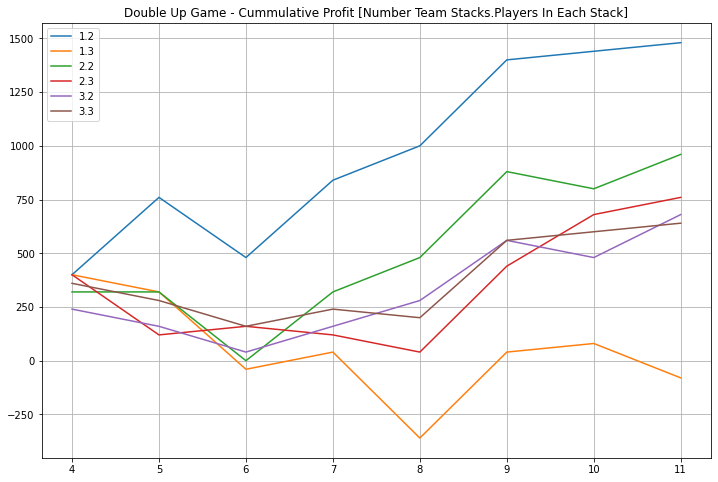

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(out).T.cumsum().plot(figsize=(12,8), title='Double Up Game - Cummulative Profit [Number Team Stacks.Players In Each Stack]')
plt.grid(True)